In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.gen_tables.search_best_inter as search_inter

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv') 
GRAPH_PATH = os.path.join(HOME, 'data/graphs')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

In [3]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Seq

In [27]:
# run python scripts to generate all the pickles needed
gen_seq = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_seq.py')   
%run $gen_seq 

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
print(df_seq.columns)

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'grid_x', 'grid_y',
       'grid_z', 'block_x', 'block_y', 'block_z', 'ctas/SM', 'runtime', 'ipc',
       'instructions', 'l2_parallelism', 'avg_mem_lat', 'avg_core_to_l2',
       'avg_l2_to_core', 'avg_mrq_latency', 'stall_core_ldst',
       'stall_icnt_to_l2', 'l2_BW', 'l2_rshr_entry_fail', 'l2_rshr_merge_fail',
       'stall_l2_to_icnt', 'l1D_miss_rate', 'l2_miss_rate',
       'l2_total_accesses', 'packet_lat_out', 'network_lat_out', 'inject_out',
       'accepted_out', 'packet_lat_in', 'network_lat_in', 'inject_in',
       'accepted_in', 'mem_subpartition_parallism',
       'mem_subpartition_parallism_util', 'L2_reservation_fail', 'empty_warp',
       'stall_warp', 'idle_warp', 'scoreboard_warp', 'tot_warp_insn', 'regs',
       'smem', 'mem_count', 'sp_winsn', 'dp_winsn', 'int_winsn',
       'tensor_winsn', 'sfu_winsn', 'mem_insn', 'sp_busy', 'dp_busy',
       'int_busy', 'tensor_busy', 'sfu_busy', 'barrier_cycles',
       'in

In [26]:
col_seq = ['pair_str', 'runtime', #'instructions', 
           'ipc',
           'avg_dram_bw', 
           'avg_core_to_l2', 'l2_miss_rate', 'l2_BW',
           # 'avg_dram_eff', 'avg_mem_lat', 'MPKI', 
           'waves',
           'regs', 'smem',
#            'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy',
#            'barrier_cycles', 'inst_empty_cycles', 'branch_cycles', 'scoreboard_cycles', 
#            'stall_sp_cycles', 'stall_dp_cycles', 'stall_int_cycles', 'stall_tensor_cycles', 'stall_sfu_cycles', 
#            'stall_mem_cycles', 'not_selected_cycles',
#            'avg_row_locality',
#            'not_selected_cycles', 'inst_empty_cycles',
          ]
df_seq.sort_values('pair_str', inplace=True)
df_seq.reset_index(inplace=True, drop=True)
draw_table(df_seq, col_seq, False).format(
    {'avg_dram_bw':'{:.4f}', 
     'ratio_dram_bw': '{:.2f}',
     'sp_busy': '{:.2f}',
     'dp_busy': '{:.2f}',
     'int_busy': '{:.2f}',
     'tensor_busy': '{:.2f}',
     'sfu_busy': '{:.2f}',
     'MPKI': '{:.2f}',
     'waves': '{:.2f}',
     'l2_total_accesses': '{:,}',
     'l2_access_density': '{:.1f}',
     'instructions': '{:,}',
     'runtime': '{:,}',
    })

,pair_str,runtime,ipc,avg_dram_bw,avg_core_to_l2,l2_miss_rate,l2_BW,waves,regs,smem
0,cut_sgemm-0,"88,621",2577.13,0.0937,127,0.5388,227.782,0.80,122,16400
1,cut_sgemm-1,"1,195,192",5505.45,0.1333,355,0.2932,304.829,3.20,122,16400
2,cut_wmma-0,"53,746",676.722,0.0188,122,0.1602,368.997,0.40,255,10256
3,cut_wmma-2,"816,033",1277.9,0.1816,340,0.1796,670.706,3.20,255,10256
4,nvd_binomial-0,"1,390,286",4411.67,0.0000,64,0.0926,0.5586,0.80,32,516
5,nvd_blackscholes-0,"184,062",1586.4,0.7727,2347,0.9987,522.259,12.21,26,0
6,nvd_fdtd3d-0,"2,140,304",1482.38,0.4517,89,0.8289,385.446,3.60,80,3840
7,nvd_interval-0,"67,309",1443.13,0.0193,146,0.7395,158.625,1.07,80,0
8,nvd_sobol-0,"113,906",6062.44,0.5696,33,0.9729,433.287,20.00,23,128
9,parb_cutcp-0,"630,050",745.805,0.0000,22,0.0428,11.3194,0.09,29,4116


# Intra

In [12]:
gen_intra = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_intra.py')
%run $gen_intra

In [13]:
df_intra = pd.read_pickle(os.path.join(PKL_PATH, 'intra.pkl'))
print(df_intra.shape)
col_intra = ['pair_str', 'intra', 'norm_ipc']

# draw_table(df_intra, col_intra)

(128, 99)


In [14]:
df_intra_best = pd.read_pickle(os.path.join(PKL_PATH, 'intra_best.pkl'))
df_intra_best.sort_values('pair_str', inplace=True)
col_intra_best = ['pair_str', 
        'perfdollar', 'intra', 'norm_ipc', 
        'runtime',
        #'l2_miss_rate',
        #'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
        'comp_busy', 'dram_busy', 'avg_dram_bw', 'avg_dram_eff']

draw_table(df_intra_best, col_intra_best).format({'norm_ipc': "{:.4f}", 'dominant_resc': '{:.2f}'})

pair_str,perfdollar,intra,norm_ipc,runtime,comp_busy,dram_busy,avg_dram_bw,avg_dram_eff
cut_sgemm-0,1.04918,2,1.0000,88621,0.28528,0.170039,0.0937438,0.467913
cut_sgemm-1,1.04918,2,1.0000,1195192,0.755801,0.302822,0.133258,0.363275
cut_wmma-0,2.00784,2,1.0000,53746,0.0705023,0.0773905,0.0188146,0.122713
cut_wmma-2,1.67591,2,0.8347,977660,0.11863,0.655181,0.181267,0.235046
nvd_binomial-0,2.99832,5,0.9370,1483802,0.511228,0.000128366,3.36183e-05,0.128054
nvd_blackscholes-0,4.10995,4,1.0275,179138,0.162483,0.952833,0.798987,0.836217
nvd_fdtd3d-0,1.6,1,1.0000,2140304,0.189676,0.943095,0.451683,0.473308
nvd_interval-0,2.80781,4,0.8774,76711,0.144064,0.00419366,0.0012223,0.176313
nvd_sobol-0,2.41656,12,0.9062,125695,0.639,0.773712,0.516129,0.623058
parb_cutcp-0,8,2,1.0000,630050,0.106921,7.05824e-05,1.84863e-05,0.100016


In [15]:
df_bi = df_intra[df_intra['pair_str'] == 'nvd_binomial-0'].sort_values('intra')

draw_table(df_bi, col_intra)

pair_str,intra,norm_ipc
nvd_binomial-0,1,0.262484
nvd_binomial-0,2,0.481157
nvd_binomial-0,3,0.655885
nvd_binomial-0,4,0.780426
nvd_binomial-0,5,0.936976
nvd_binomial-0,6,0.937568
nvd_binomial-0,7,0.987903
nvd_binomial-0,8,0.99594
nvd_binomial-0,9,0.996852
nvd_binomial-0,10,0.997465


# Find intra pairs

In [16]:
col_prod = ['norm_ipc_x', 'norm_ipc_y', 'diff_mflat', 'sum_ipc', 
            'intra_x', 'intra_y', 
           'sum_comp', 'sum_dram', 'penalized']
find_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_pair_configs.py')


app1 = widgets.Dropdown(
    options=df_seq['pair_str'],
    value='cut_sgemm-1',
    rows=5,
    description='App 1:',
    disabled=False
)

app2 = widgets.Dropdown(
    options=df_seq['pair_str'],
    value='cut_sgemm-1',
    rows=5,
    description='App 2:',
    disabled=False
)

qos = widgets.FloatSlider(
    value=0.75,
    min=0.1,
    max=0.95,
    step=0.05,
    description='QoS:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

button = widgets.Button(description='Calculate', button_style='info')

def show_widgets():
    display(app1)
    display(app2)
    display(qos)
    display(button)
    
show_widgets()

def onclick(b):
    clear_output()
    show_widgets()
    %run $find_pair --app $app1.value $app2.value --qos $qos.value
    
    df_prod = pd.read_pickle(os.path.join(PKL_PATH, 'pair_candidates.pkl'))
    print(df_prod.columns)
#     sns.lineplot('diff_mflat', 'sum_ipc', data=df_prod)
   
    display(HTML(draw_table(df_prod, col_prod, False).render()))
    
    
button.on_click(onclick)

Dropdown(description='App 1:', index=1, options=('cut_sgemm-0', 'cut_sgemm-1', 'cut_wmma-0', 'cut_wmma-2', 'nv…

Dropdown(description='App 2:', index=1, options=('cut_sgemm-0', 'cut_sgemm-1', 'cut_wmma-0', 'cut_wmma-2', 'nv…

FloatSlider(value=0.75, continuous_update=False, description='QoS:', max=0.95, min=0.1, step=0.05)

Button(button_style='info', description='Calculate', style=ButtonStyle())

In [ ]:
sum_jobs = 0
sum_feasible_pairs = 0
sum_checked_pairs = 0
arr_jobs = []

intra_pkl_path = os.path.join(PKL_PATH, 'intra.pkl')
benchmarks = [b for b in const.kernel_yaml.keys() if b not in const.multi_kernel_app]

for bench1 in benchmarks:
    for bench2 in benchmarks:
        if bench1 < bench2:
            bench1_name = bench1.split('-')[0]
            bench2_name = bench2.split('-')[0]
            if bench1_name != bench2_name:
                sum_checked_pairs += 1
                feasible = len(gen_pair.build_df_prod(intra_pkl_path, 0.65, [bench1, bench2], 2.5, top_only=False).index)
                if feasible > 0:
                    arr_jobs.append((bench1, bench2))
                    sum_feasible_pairs += 1
                    sum_jobs += feasible
                
print('=== Intra-SM Pair Jobs ===')
print('Number of checked pairs: ', sum_checked_pairs) 
print('Number of feasible pairs: ', sum_feasible_pairs)
print('Number of jobs: ', sum_jobs)

Error. No feasible pair configs for ('cut_sgemm-1', 0)+('nvd_fdtd3d-0', 0) at QoS 0.65.
Error. No feasible pair configs for ('cut_sgemm-0', 0)+('nvd_fdtd3d-0', 0) at QoS 0.65.


In [58]:
# Find what's missing in pair_intra
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
df_bench = df_dynamic[['1_bench', '2_bench']]
arr_pair = [tuple(x) for x in df_bench.to_numpy()]
arr_pair = list(dict.fromkeys(arr_pair))
print(len(arr_pair))

diff = set(arr_jobs) - set(arr_pair)
print(list(diff))

134
[('cut_wmma-0', 'nvd_sobol-0')]


# Inter

In [117]:
gen_inter = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_inter.py')
%run $gen_inter

In [118]:
df_inter = pd.read_pickle(os.path.join(PKL_PATH, 'inter.pkl'))
print(len(df_inter['pair_str'].unique()))
print(df_inter[df_inter['inter'] == 80][['pair_str', 'norm_ipc']])

17
                pair_str  norm_ipc
6         nvd_binomial-0  1.000000
16         rod_hotspot-0  1.000000
26           parb_spmv-0  0.999343
36       rod_hotspot3d-0  0.997882
46           nvd_sobol-0  1.000000
56        nvd_interval-0  1.000000
66          rod_lavamd-0  1.016199
76      rod_pathfinder-0  1.000000
86            cut_wmma-0  1.013731
96       rod_heartwall-0  1.000000
106   nvd_blackscholes-0  1.000000
116         nvd_fdtd3d-0  1.000000
126       parb_stencil-0  1.000000
136           parb_lbm-0  1.000000
146  rod_streamcluster-0  0.993655
156         parb_cutcp-0  1.000000
166          cut_sgemm-1  1.000000


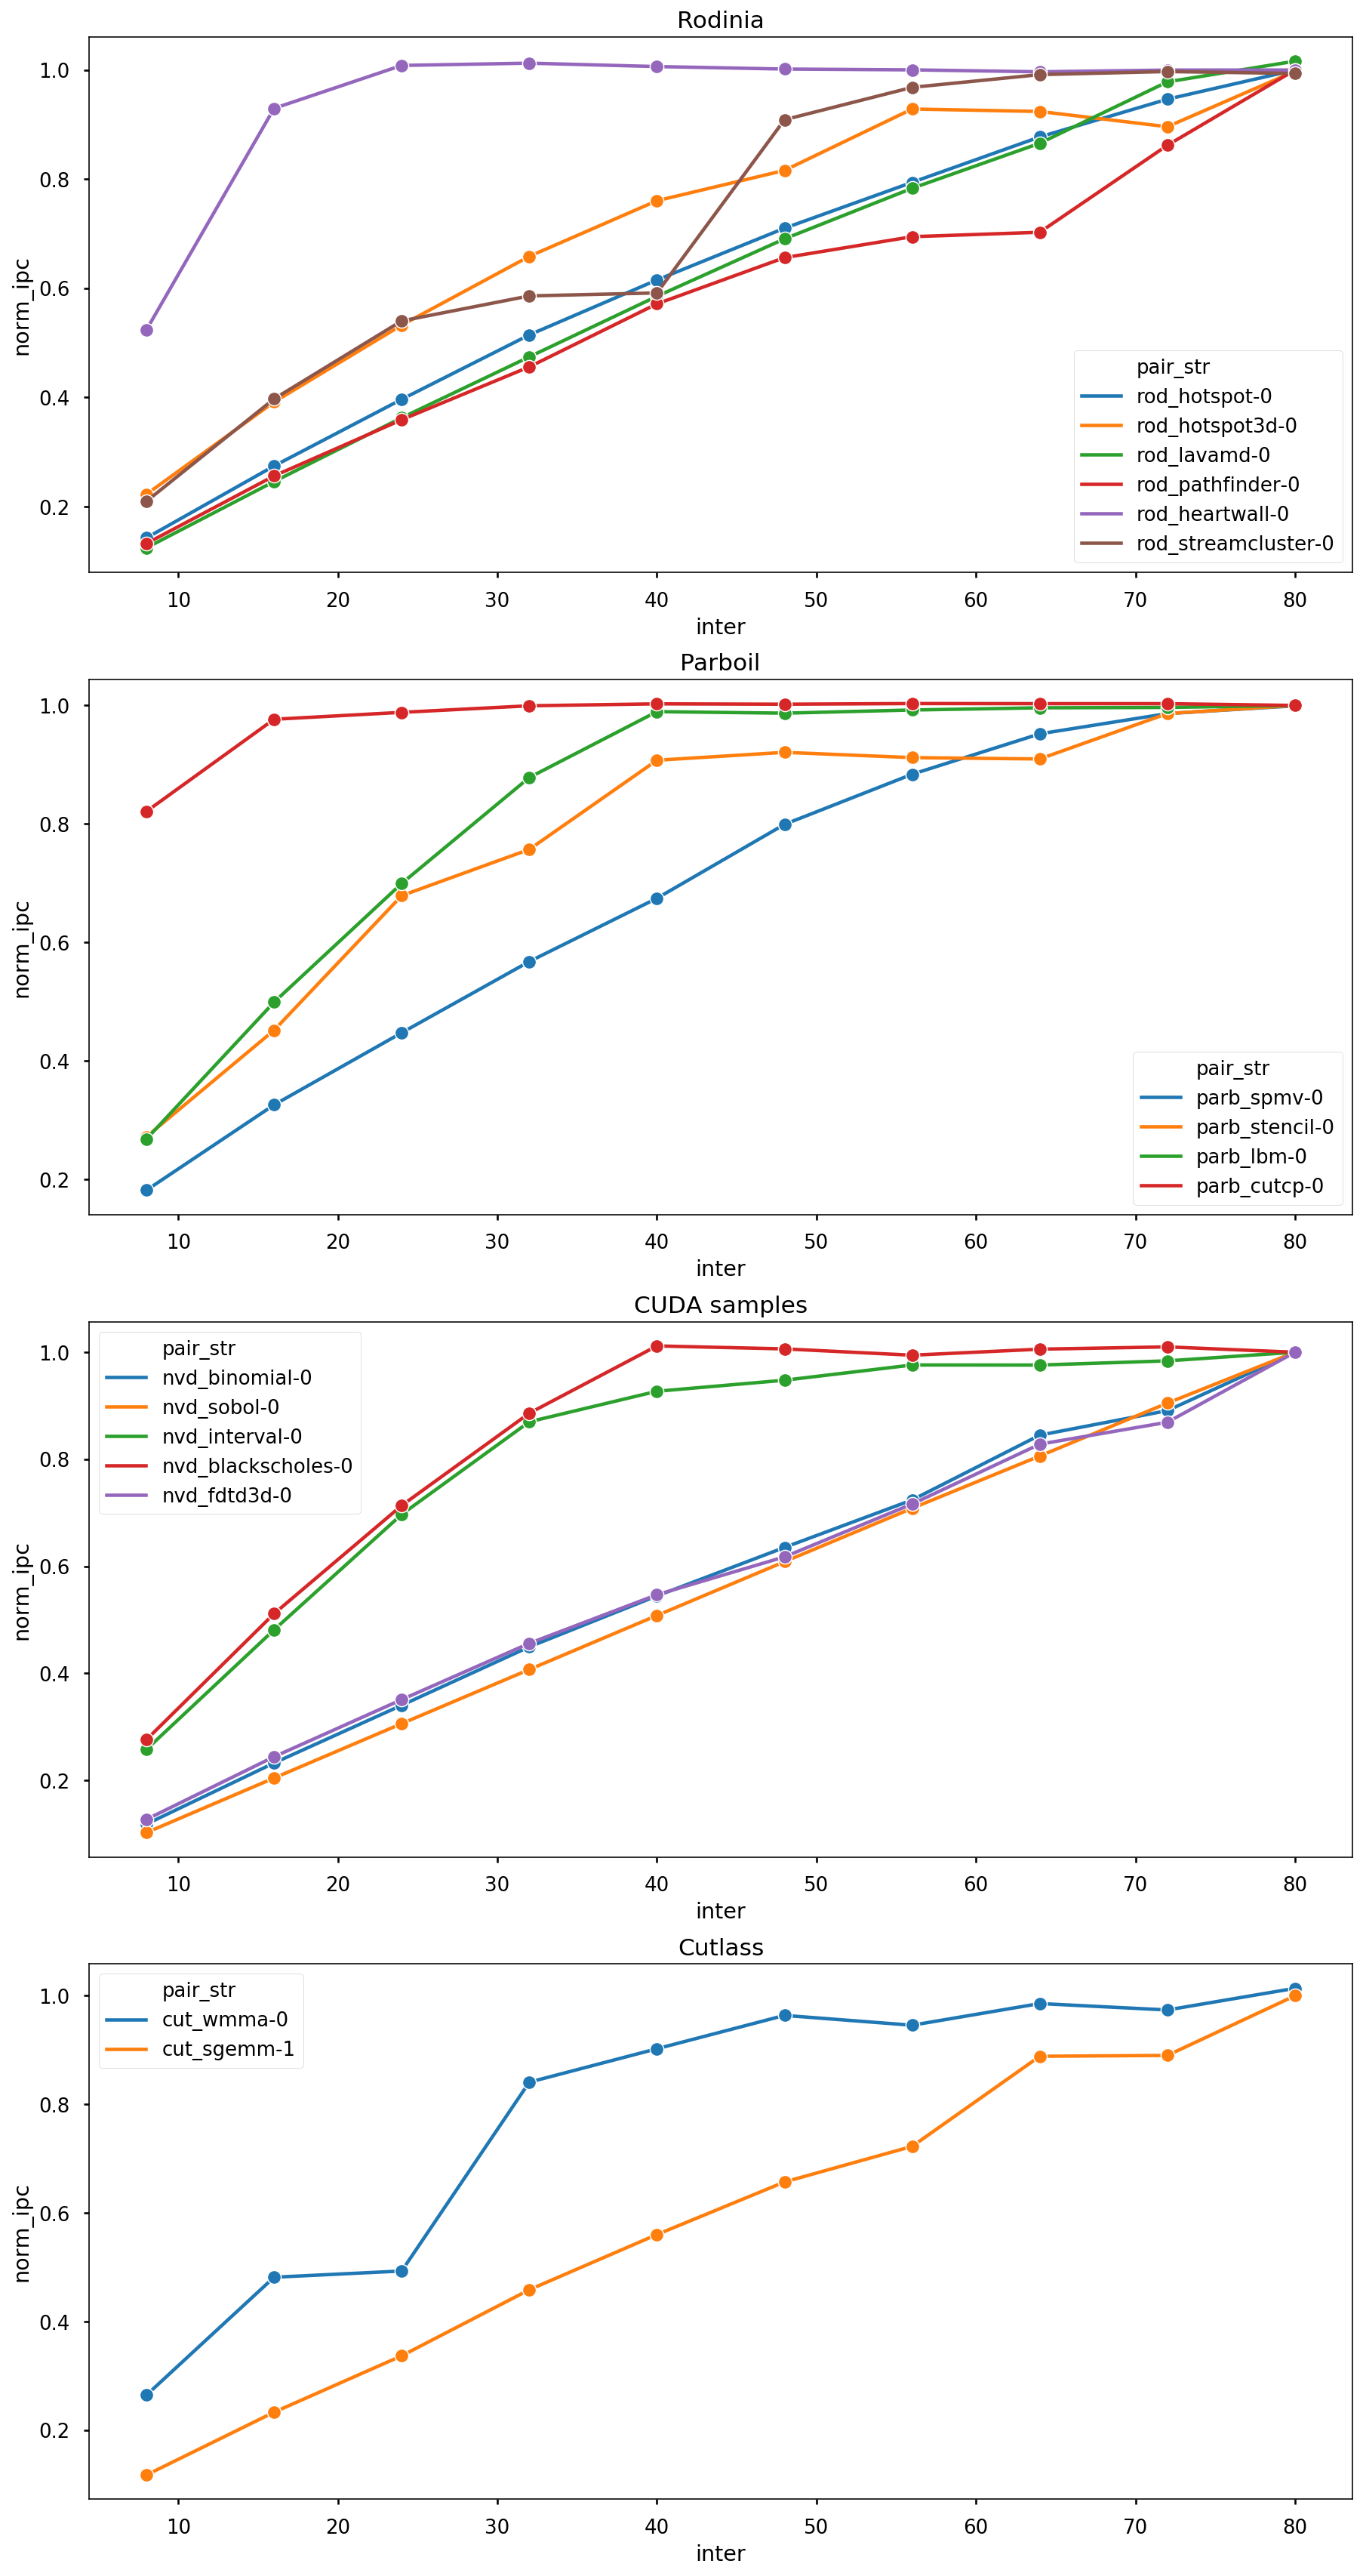

In [119]:
# Show runtime v.s. # of SMs
f, axs = plt.subplots(4,1,figsize=(15, 30))
plt.subplot(411)
data = df_inter[df_inter['pair_str'].str.contains('rod_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Rodinia')

plt.subplot(412)
data = df_inter[df_inter['pair_str'].str.contains('parb_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Parboil')

plt.subplot(413)
data = df_inter[df_inter['pair_str'].str.contains('nvd_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('CUDA samples')

plt.subplot(414)
data = df_inter[df_inter['pair_str'].str.contains('cut_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Cutlass')

plt.savefig(os.path.join(GRAPH_PATH, 'sm-sensitivity.pdf'), bbox_inches='tight')

In [ ]:
# Show runtime v.s. number of thread block waves
def calc_wave(row):
    return const.app_dict[row['pair_str']][1] / (const.app_dict[row['pair_str']][0] * row['inter'])

df_inter['waves'] = df_inter.apply(lambda row: calc_wave(row), axis=1)

# divide kernels based on min waves
df_groupby = df_inter[['pair_str', 'waves']].groupby(['pair_str']).min()
lt_one = df_groupby[df_groupby['waves'] < 1].index.to_list()
gt_one = df_groupby[df_groupby['waves'] >= 1].index.to_list()

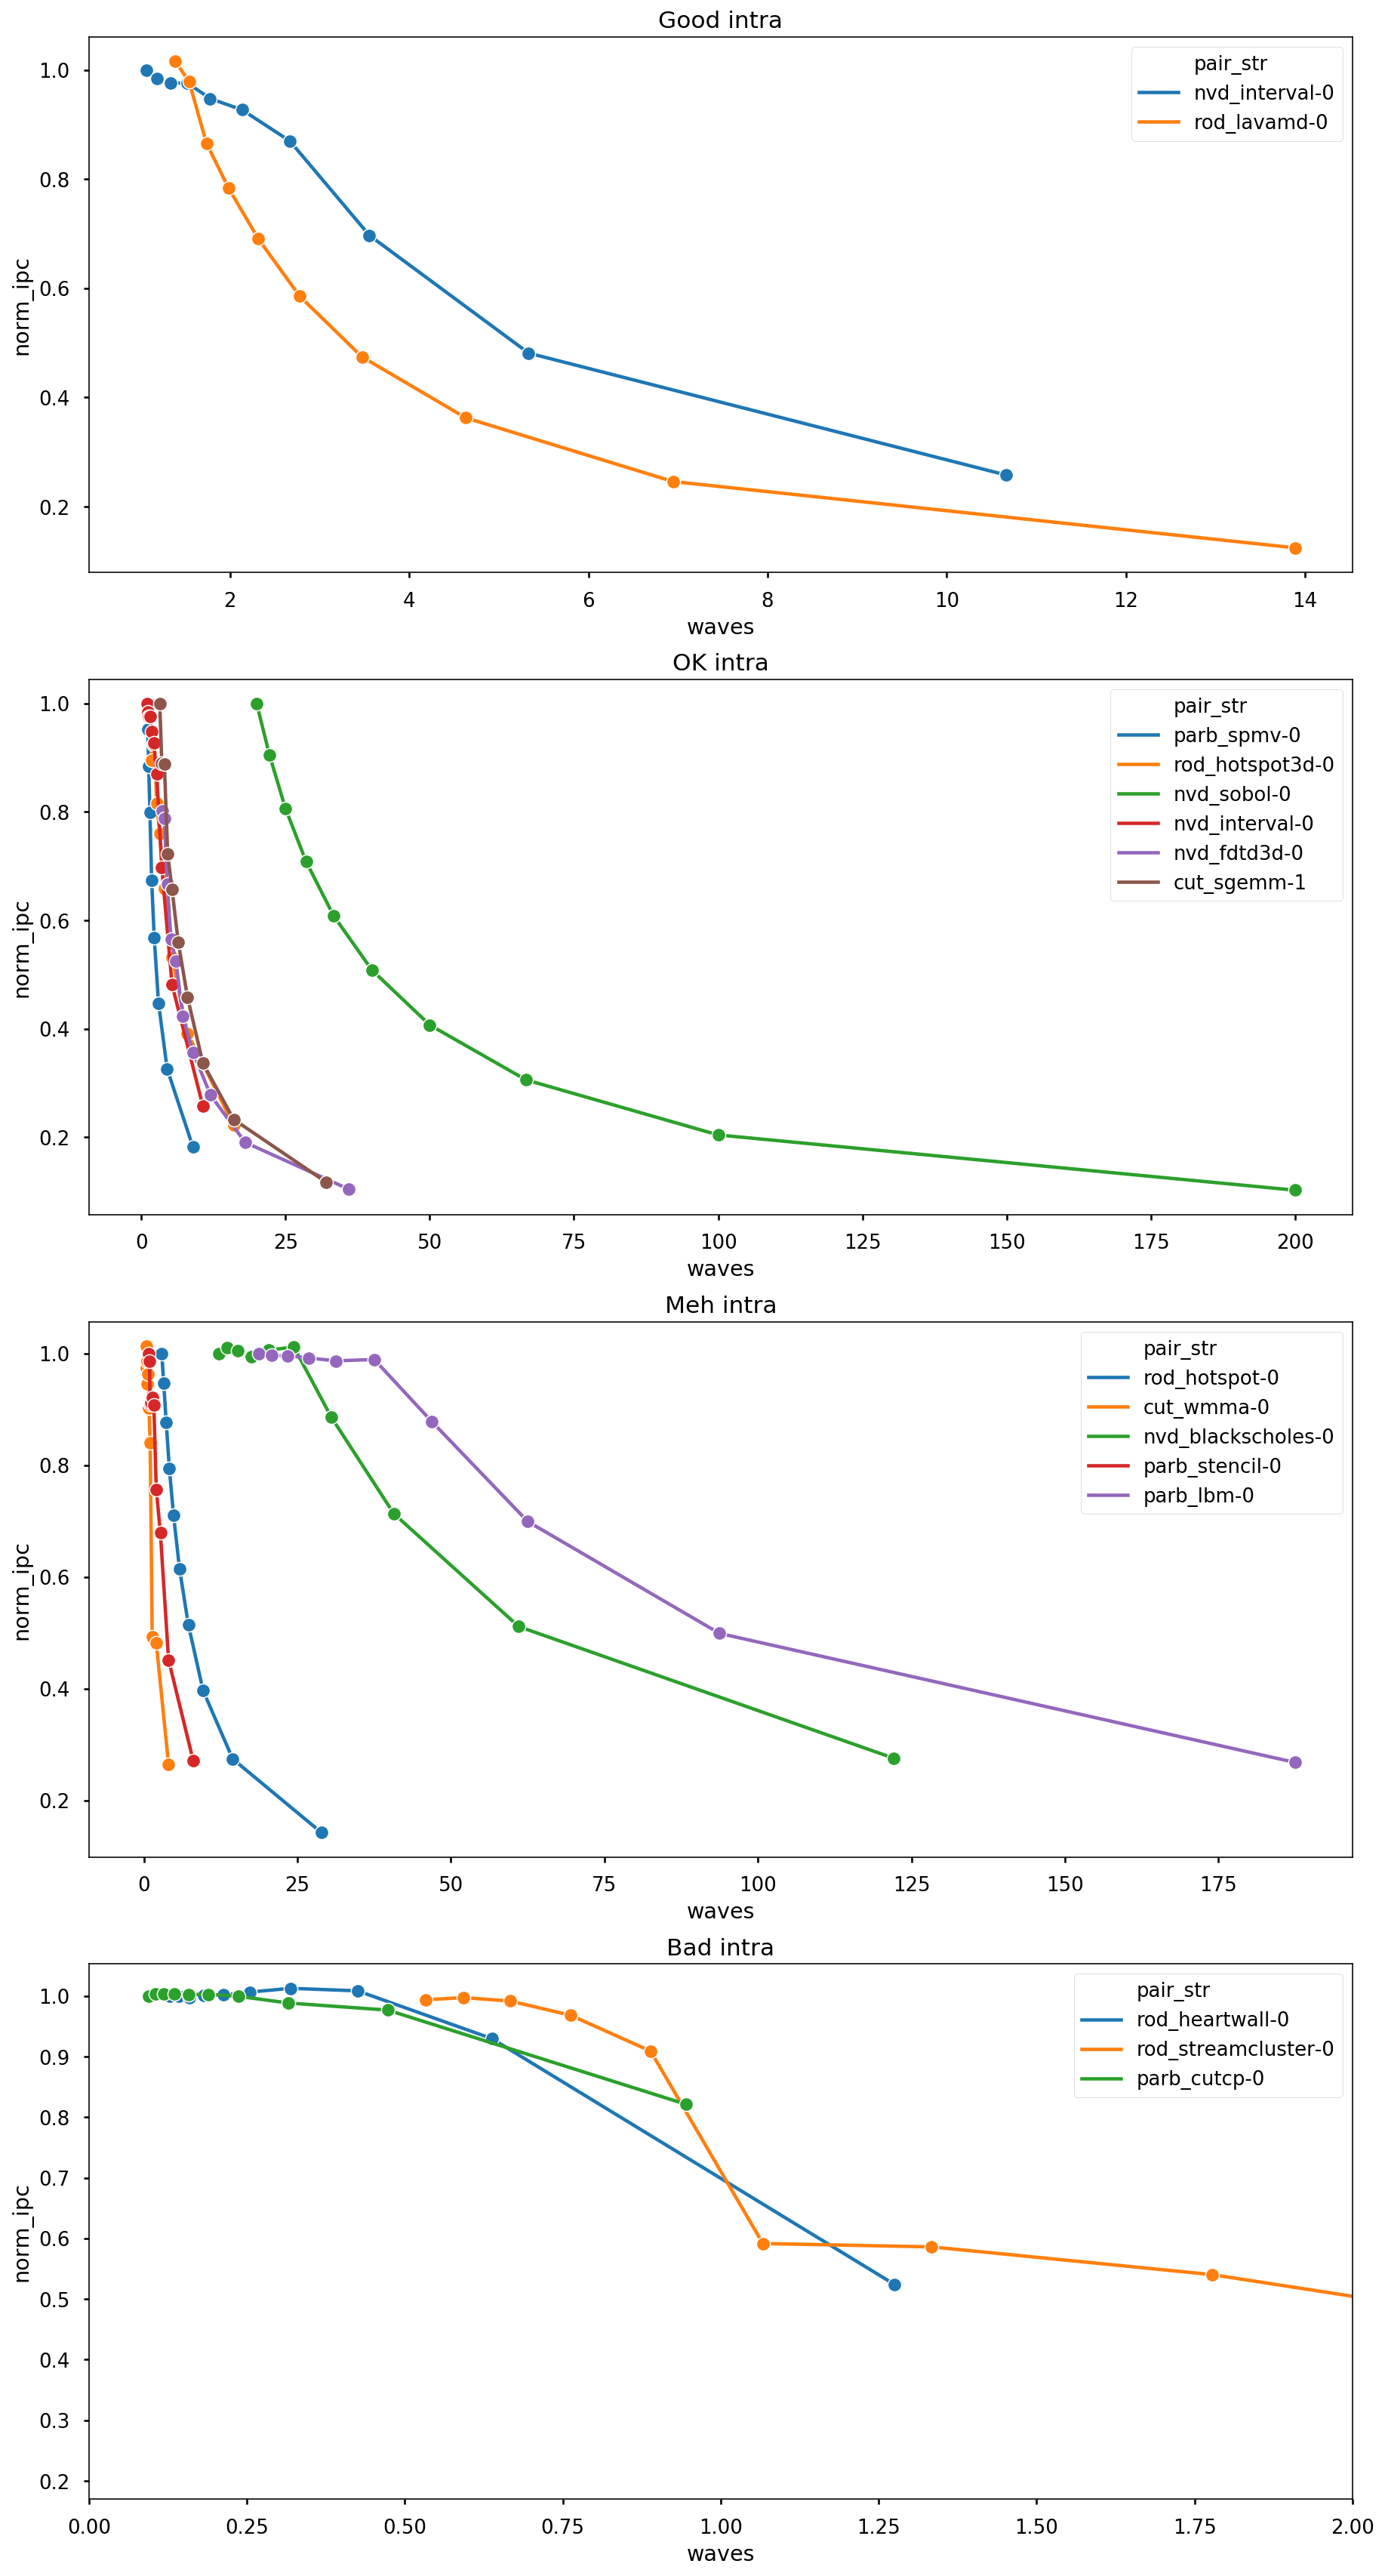

In [112]:
f, axs = plt.subplots(2,1,figsize=(15, 30))
plt.subplot(411)
good_intra = ['rod_lavamd-0', 'nvd_interval-0']
data = df_inter[df_inter['pair_str'].isin(good_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Good intra')

plt.subplot(412)
ok_intra = ['nvd_fdtd3d-0', 'nvd_sobol-0', 'cut_sgemm-1', 'nvd_interval-0', 'parb_spmv-0', 'rod_hotspot3d-0']
data = df_inter[df_inter['pair_str'].isin(ok_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
# plt.xlim([0, 2])
plt.title('OK intra')

plt.subplot(413)
meh_intra = ['cut_wmma-0', 'parb_stencil-0', 'nvd_blackscholes-0', 'rod_hotspot-0', 'parb_lbm-0']
data = df_inter[df_inter['pair_str'].isin(meh_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Meh intra')

plt.subplot(414)
bad_intra = ['parb_cutcp-0', 'rod_heartwall-0', 'rod_streamcluster-0']
data = df_inter[df_inter['pair_str'].isin(bad_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.xlim([0, 2])
plt.title('Bad intra')

# plt.subplot(414)
# data = df_inter[df_inter['pair_str'].str.contains('cut_')]
# sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
# plt.title('Cutlass')

# plt.savefig(os.path.join(GRAPH_PATH, 'sm-sensitivity.pdf'), bbox_inches='tight')
plt.show()

Dropdown(description='App 1:', index=11, options=('nvd_binomial-0', 'rod_hotspot-0', 'parb_spmv-0', 'rod_hotsp…

Dropdown(description='App 2:', index=3, options=('nvd_binomial-0', 'rod_hotspot-0', 'parb_spmv-0', 'rod_hotspo…

Button(button_style='info', description='Calculate', style=ButtonStyle())

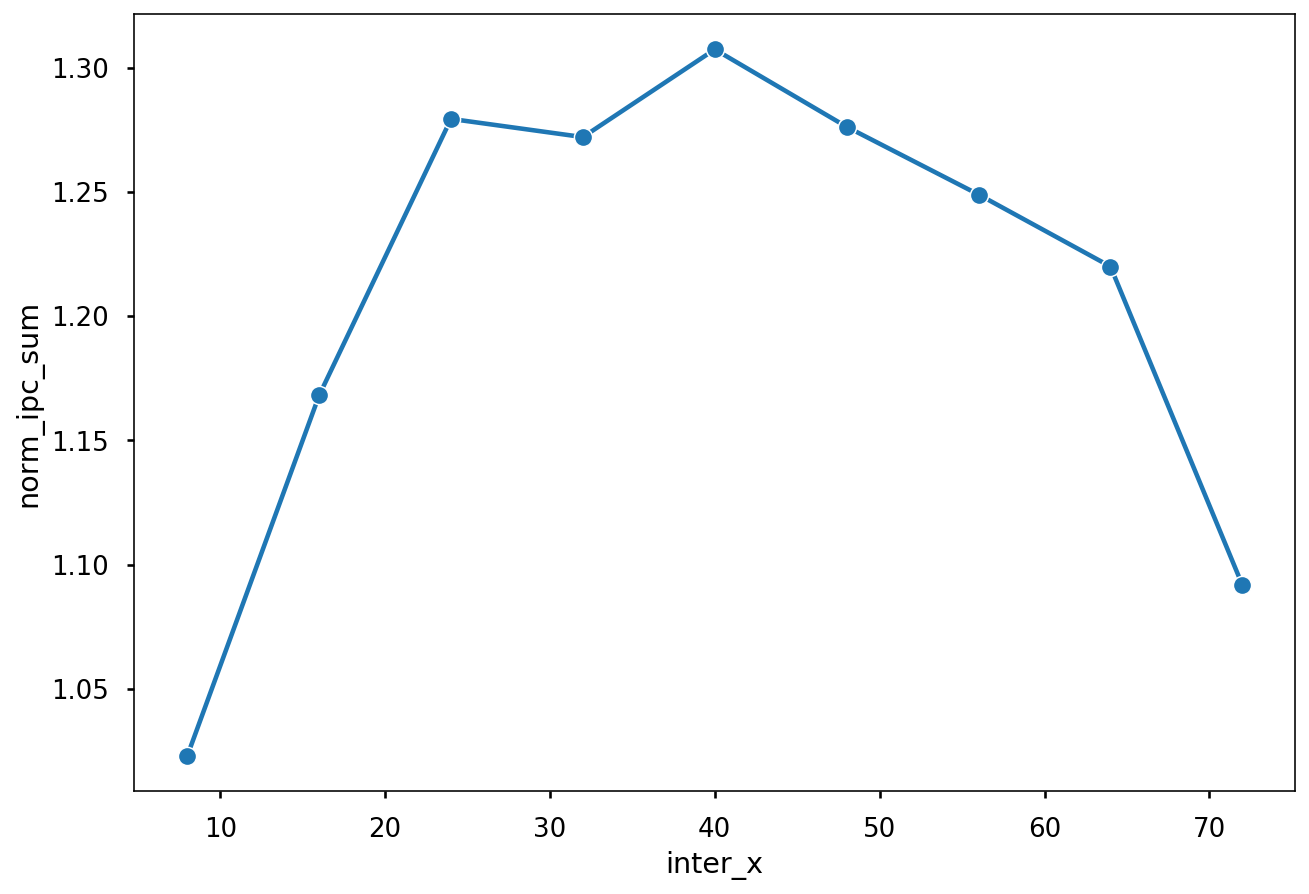

pair_str_x,pair_str_y,inter_x,inter_y,inter_sum,norm_ipc_x,norm_ipc_y,norm_ipc_sum,config
nvd_fdtd3d-0,rod_hotspot3d-0,40,40,80,0.546801,0.760507,1.30731,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350762_CYCLE-INTER_0:40:40_SM
nvd_fdtd3d-0,rod_hotspot3d-0,24,56,80,0.350817,0.928526,1.27934,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350762_CYCLE-INTER_0:24:56_SM
nvd_fdtd3d-0,rod_hotspot3d-0,48,32,80,0.617605,0.658551,1.27616,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350761_CYCLE-INTER_0:48:32_SM
nvd_fdtd3d-0,rod_hotspot3d-0,32,48,80,0.455954,0.816068,1.27202,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350762_CYCLE-INTER_0:32:48_SM
nvd_fdtd3d-0,rod_hotspot3d-0,56,24,80,0.716336,0.532576,1.24891,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350761_CYCLE-INTER_0:56:24_SM
nvd_fdtd3d-0,rod_hotspot3d-0,64,16,80,0.828193,0.391756,1.21995,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350761_CYCLE-INTER_0:64:16_SM
nvd_fdtd3d-0,rod_hotspot3d-0,16,64,80,0.244033,0.924053,1.16809,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350764_CYCLE-INTER_0:16:64_SM
nvd_fdtd3d-0,rod_hotspot3d-0,72,8,80,0.8692,0.222591,1.09179,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350760_CYCLE-INTER_0:72:8_SM
nvd_fdtd3d-0,rod_hotspot3d-0,8,72,80,0.126927,0.896072,1.023,TITANV-PAE-CONCURRENT-SEP_RW-LSRR-CAP_5350763_CYCLE-INTER_0:8:72_SM


In [120]:
app1 = widgets.Dropdown(
    options=df_inter['pair_str'].unique(),
    value='cut_sgemm-1',
    rows=5,
    description='App 1:',
    disabled=False
)

app2 = widgets.Dropdown(
    options=df_inter['pair_str'].unique(),
    value='cut_sgemm-1',
    rows=5,
    description='App 2:',
    disabled=False
)

qos = widgets.FloatSlider(
    value=0.75,
    min=0.1,
    max=0.95,
    step=0.05,
    description='QoS:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

button = widgets.Button(description='Calculate', button_style='info')

def show_widgets():
    display(app1)
    display(app2)
#     display(qos)
    display(button)
    
show_widgets()

def onclick(b):
    clear_output()
    show_widgets()

#     df_a1 = df_inter[df_inter['pair_str'] == app1.value].copy()
#     df_a1['key'] = 0
#     df_a2 = df_inter[df_inter['pair_str'] == app2.value].copy()
#     df_a2['key'] = 0
    
#     df_prod = df_a1.merge(df_a2, how='outer', on='key')
#     df_prod.drop(columns=['key'])
#     df_prod['inter_sum'] = df_prod['inter_x'] + df_prod['inter_y']
#     df_prod['norm_ipc_sum'] = df_prod['norm_ipc_x'] + df_prod['norm_ipc_y']
    
#     df_prod = df_prod[df_prod['inter_sum'] == 80]
#     df_prod.sort_values('inter_x', inplace=True, ascending=True)
    col_prod_inter = ['pair_str_x', 'pair_str_y', 'inter_x', 'inter_y', 'inter_sum',
                      'norm_ipc_x', 'norm_ipc_y', 'norm_ipc_sum', 'config']

    find_inter_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_inter_configs.py')
    %run $find_inter_pair --app $app1.value $app2.value
    
    df_prod = pd.read_pickle(os.path.join(PKL_PATH, 'inter_candidates.pkl'))
    
    sns.lineplot(x='inter_x', y='norm_ipc_sum', data=df_prod, marker='o')
    plt.show()
    display(HTML(draw_table(df_prod, col_prod_inter).render()))
    
    
button.on_click(onclick)

In [131]:
sum_jobs = 0
sum_feasible_pairs = 0
sum_checked_pairs = 0
arr_jobs = []

inter_pkl_path = os.path.join(PKL_PATH, 'inter.pkl')
pair_inter_pkl_path = os.path.join(PKL_PATH, 'pair_inter.pkl')

for bench1 in const.app_for_pair:
    for bench2 in const.app_for_pair:
        if bench1 < bench2:
            sum_checked_pairs += 1
            feasible = len(search_inter.build_configs_local(inter_pkl_path, pair_inter_pkl_path, [bench1, bench2], 2))
            if feasible > 0:
                arr_jobs.append((bench1, bench2))
                sum_feasible_pairs += 1
                sum_jobs += feasible
                
print('=== Inter-SM Pair Jobs ===')
print('Number of checked pairs: ', sum_checked_pairs) 
print('Number of feasible pairs: ', sum_feasible_pairs)
print('Number of jobs: ', sum_jobs)

=== Inter-SM Pair Jobs ===
Number of checked pairs:  136
Number of feasible pairs:  5
Number of jobs:  5
